# Transition path theory

Transition path theory (TPT) <cite data-footcite="weinan2006towards">(E, 2006)</cite><cite data-footcite="metzner2009transition">(Metzner, 2009)</cite> is a method to study the ensemble of reactive trajectories, i.e., trajectories which come from a defined set of states $A$ and go next to $B$. It can answer at which rate they occur, as well as depict parallel pathways, traps, sequences of events, etc. Furthermore it introduces the notion of 'committor functions', which deals with probabilities of ending up in set $A$ or $B$ given the trajectory starts at some state potentially outside $A\cup B$.

The implementation is based on <cite data-footcite="noe2009constructing">(Noe, 2009)</cite>. Coarse-graining by path decomposition is presented in <cite data-footcite="noe2009constructing">(Noe, 2009)</cite> and <cite data-footcite="berezhkovskii2009reactive">(Berezhokovskii, 2009)</cite>.
    
To demonstrate the TPT API ([API docs here](../api/generated/deeptime.markov.ReactiveFlux.rst#deeptime.markov.ReactiveFlux)), in the following the example of a drunkard's walk is presented. The example is motivated by <cite data-footcite="doyle1984random">(Doyle, 1984)</cite> and <cite data-footcite="valleriani2015circular">(Valleriani, 2015)</cite>, where a drunkard is placed on a network of states and two special states, home and the bar. When the drunkard reaches either of these special states the trajectory stays there with high probability.
One can then ask which paths can be taken and also with which probability the drunkard is going to reach either of the states given a certain current position.

To this end, import numpy for general numerical operations.

In [1]:
import numpy as np

We can create a [DrunkardsWalk](../api/generated/deeptime.data.drunkards_walk.rst#deeptime.data.drunkards_walk) simulator by specifying bar and home locations. As the drunkard lives on a 2-dimensional grid, the locations are given in terms of integer coordinates. Internally, this is related back to $\mathrm{width}\times\mathrm{height}$ states. 

There are four kinds of states:
- home states: states which denote the location of the home
- bar states: states which denote the location of the bar
- barrier states: states which either cannot be crossed or can only be crossed by overcoming a potential (i.e., it is less likely to encounter these states in a trajectory)
- normal states: the drunkard can move freely by taking a step onto one of the adjacent grid cells with uniform probability unless it is a barrier.

In [2]:
from deeptime.data import drunkards_walk

sim = drunkards_walk(grid_size=(10, 10),
                     bar_location=[(0, 0), (0, 1), (1, 0), (1, 1)], 
                     home_location=[(8, 8), (8, 9), (9, 8), (9, 9)])

We can add hard and soft barriers by specifying start and end points of the barrier. If no weight is given, the barrier is `hard`, i.e., cannot be crossed by a trajectory. This enters the jump probabilities from adjacent cells $(i,j)$ as

$$
\mathbb{P}(x_{t+1}=\mathrm{barrier} \mid x_t = (i, j)) = \begin{cases} p \leq 1/\mathrm{weight} &\text{, if weight positive,}\\ 0 &\text{, otherwise.} \end{cases}
$$

That means the larger the weight, the smaller the probability to cross the barrier.

In [3]:
sim.add_barrier((5, 1), (5, 5))
sim.add_barrier((0, 9), (5, 8))
sim.add_barrier((9, 2), (7, 6))
sim.add_barrier((2, 6), (5, 6))

sim.add_barrier((7, 9), (7, 7), weight=5.)
sim.add_barrier((8, 7), (9, 7), weight=5.)

sim.add_barrier((0, 2), (2, 2), weight=5.)
sim.add_barrier((2, 0), (2, 1), weight=5.)

Now we can simulate a trajectory on this grid by specifying a starting point and a number of simulation steps. The effective length of the trajectory might be lower than the number of simulation steps as the simulation stops if the state is `home` or `bar`.

In [4]:
start = (7, 2)
walk = sim.walk(start=start, n_steps=250, seed=40)
print("Number of steps in the walk:", len(walk))

Number of steps in the walk: 74


The trajectory can be visualized with a few helper functions attached to the simulator:

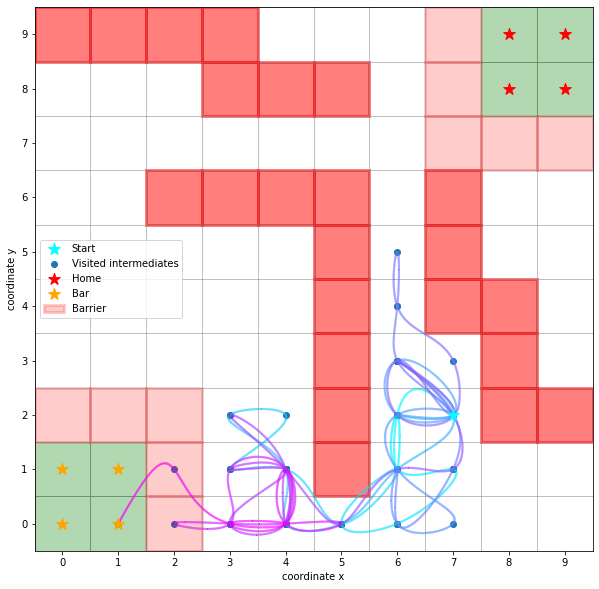

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(*start, marker='*', label='Start', c='cyan', s=150, zorder=5)
sim.plot_path(ax, walk)
handles, labels = sim.plot_2d_map(ax)
ax.legend(handles=handles, labels=labels);

Here, the darker red squares denote hard barriers, the lighter red squares denote barriers which can be crossed. So one could imagine, that both home and bar are on a hill.

The simulator internally holds a [MarkovStateModel](../api/generated/deeptime.markov.msm.MarkovStateModel.rst#deeptime.markov.msm.MarkovStateModel) on which one can call [reactive_flux(A, B)](../api/generated/deeptime.markov.msm.MarkovStateModel.rst#deeptime.markov.msm.MarkovStateModel.reactive_flux). This computes some quantities related to the ensemble of reactive trajectories between sets of states $A$ and $B$.

In [6]:
print(f"Internal Markov state model with {sim.msm.n_states} states to cover the {sim.grid_size} grid.")
print(f"Compute reactive flux from A={sim.home_state} to B={sim.bar_state}")
flux = sim.msm.reactive_flux(sim.home_state, sim.bar_state)

Internal Markov state model with 100 states to cover the (10, 10) grid.
Compute reactive flux from A=[88, 98, 89, 99] to B=[0, 10, 1, 11]


## The committor

One of the questions that can be answered with TPT is: If the man is at some state $(i,j)$, what is the probability that he reaches the bar before home? If he is already already at the bar, the probability is $1$, i.e., 

$$\mathbb{P}((i,j)) = 0\;\forall (i,j)\in\mathrm{Home}$$ 

and vice versa

$$\mathbb{P}((i,j)) = 1\;\forall (i,j)\in\mathrm{Bar}.$$

The [law of total probability](https://en.wikipedia.org/wiki/Law_of_total_probability) tells us that to know the probability of an event $A$ with a known and at most countably infinite set of mutually exclusive events $\{C_n : n\in\mathbb{N}\}$ so that $\sum_i \mathbb{P}(C_i) = 1$, one can evaluate

$$
\mathbb{P}(A) = \sum_n \mathbb{P}(A\mid C_n)\mathbb{P}(C_n).
$$

In our example and ignoring borders and barriers, this means that for a current state $s=(i,j)$ and $A=\text{"Home from state }s\text{"}$ the sample space consists of direct neighbor states, i.e.,

$$
C = \{ \text{move from }s\text{ to }s+(k,l) : (k,l)\in \{ -1, 0, 1 \}^2 \text{ and } (k,l)\neq (0, 0) \} \}.
$$

Then,
$$
\mathbb{P}(\text{Home from }s) = \sum_{C_{(k,l)}\in C} \mathbb{P}(\text{Home from }s+(k,l))\mathbb{P}(C_{(k,l)}).
$$

But the $\mathbb{P}(C_{(k,l)})$ are exactly the transition probabilities to move from state $s$ to $s+(k,l)$, giving rise to the _forward committor_

$$
q_s^{(+)} = q_{(i,j)}^{(+)} = \sum_{(k,l)\neq(0, 0)} q_{(i+k, j+l)}^{(+)}p_{(i,j),(i+k, j+l)},
$$

where $p_{(i,j),(i+k, j+l)}$ is the probability to transition from state $s=(i,j)$ to one of its neighboring states.

**More formally**, the forward committor probability is the probability to reach set of states $A$ before $B$. Using the first hitting time of a set $S$ given by

$$T_{S}=\inf\{t \geq 0 : X_t \in S \},$$

it can be defined as

$$
q^{(+)}_i=\mathbb{P}_{i}(T_{A} < T_{B}).
$$

It also satisfies the boundary value problem (BVP)

$$
\begin{aligned}
q_i^{(+)} &= 0 &&\text{, for all }i\in A,\\
q_i^{(+)} &= 1 &&\text{, for all }i\in B,\\
\sum_j L_{ij} q^{(+)}_{j}&=0 &&\text{, for all }i\not\in A\cup B,\\
\end{aligned}
$$

where $L=P-\mathbb{I}$ is the generator matrix and $P$ the transition matrix. The BVP-formulation is used to numerically find the forward committor.

There is also the notion of a *backward committor*, which is the probability that given state $i$, the system has previously been in set $A$ rather than $B$. With detailed balance, the backward committor is given by $q_i^{(-)} = 1 - q_i^{(+)}$.

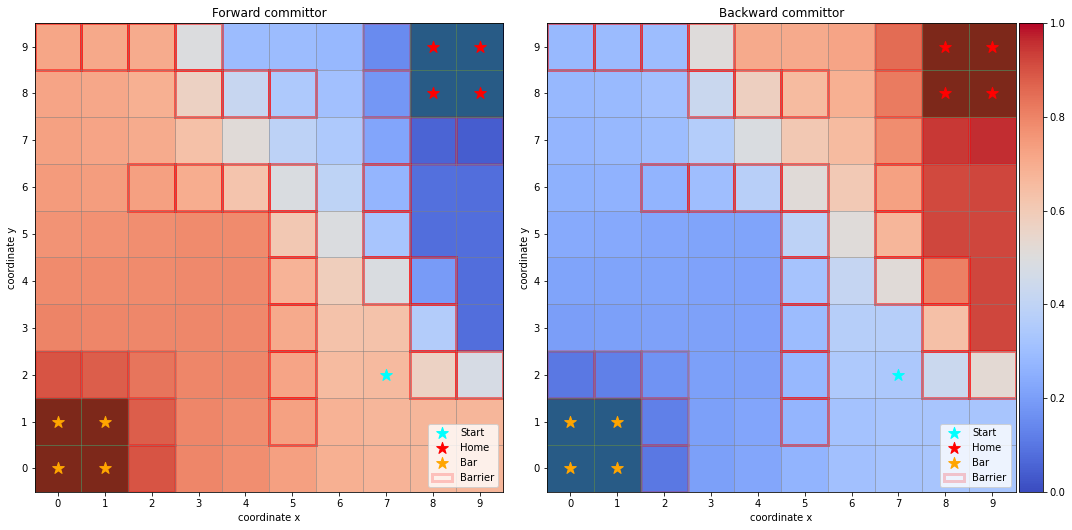

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
dividers = [make_axes_locatable(axes[i]) for i in range(len(axes))]
caxes = [divider.append_axes("right", size="5%", pad=0.05) for divider in dividers]
titles = ["Forward committor", "Backward committor"]

for i, ax in enumerate(axes):
    ax.set_title(titles[i])
    ax.scatter(*start, marker='*', label='Start', c='cyan', s=150, zorder=5)
    handles, labels = sim.plot_2d_map(ax, barrier_mode='hollow')

    if i == 0:
        Q = flux.forward_committor.reshape(sim.grid_size)
    else:
        Q = flux.backward_committor.reshape(sim.grid_size)
    cb = ax.imshow(Q, interpolation='nearest', origin='lower', cmap='coolwarm')
    fig.colorbar(cb, cax=caxes[i])
    if i == 0:
        fig.delaxes(fig.axes[2])

    ax.legend(handles=handles, labels=labels)


plt.tight_layout()

As one can observe, the forward committor probabilities increase gradually when moving from home to bar, vice versa for the backward committor. This is expected as the Markov state model is reversible.

## Reactive probability flux

If one is interested in the current of trajectories making their way from a set of states $A$ to a set of states $B$ (without trajectories that, e.g., leave $A$ just to go back to $A$ and only then enter $B$), TPT offers the *reactive flux*. The relevant _gross flux_ between two states $i$ and $j$ is then given by

$$
f_{ij}^{AB} = \begin{cases}q_i^{(-)}\pi_i p_{ij}q_j^{(+)} &\text{, if }i\neq j,\\ 0 &\text{, otherwise.}\end{cases}
$$

The flux is conserved between intermediate states

$$
\sum_j f_{ij}^{AB} - f_{ji}^{AB} = 0\;\forall i\not\in A\cup B,
$$

and also throughout the entire network

$$
\sum_{i\in A,j\not in A}f_{ij}^{AB} = \sum_{i\not\in B, j\in B} f_{ij}^{AB}.
$$

The considered _gross flux_ can include detours of the form $A\rightarrow\ldots\rightarrow i\rightarrow j\rightarrow i\rightarrow j\rightarrow\ldots\rightarrow B$, which can be (in the case of detailed balance) excluded by considering the _net flux_

$$
f_{ij}^{AB,+} = \max\{ 0, f_{ij}^{AB}-f_{ji}^{AB} \}.
$$

In general and without detailed balance, the net flux might still contain such detours.

In deeptime, the gross and net flux are accessible from the [ReactiveFlux](../api/generated/deeptime.markov.ReactiveFlux.rst) object as $(n_\mathrm{states}\times n_\mathrm{states})$ numpy arrays, where the first dimension corresponds to state $i$, the second dimension corresponds to state $j$.

In [8]:
print(f"Gross flux shape {flux.gross_flux.shape}, net flux shape {flux.net_flux.shape}")

Gross flux shape (100, 100), net flux shape (100, 100)


The example simulator offers plotting functionality so that the fluxes can be visualized:

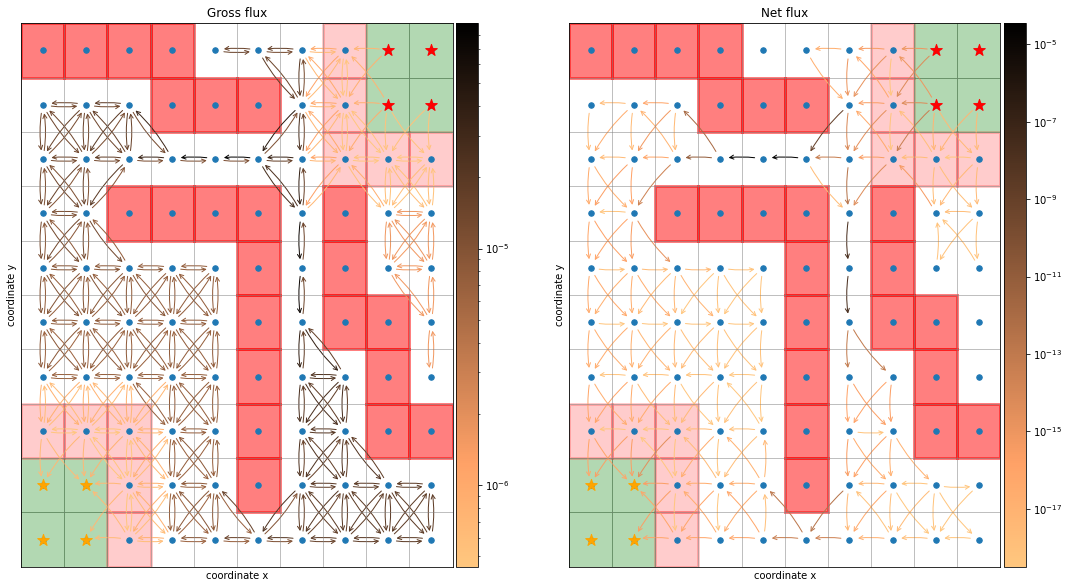

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
dividers = [make_axes_locatable(axes[i]) for i in range(len(axes))]
caxes = [divider.append_axes("right", size="5%", pad=0.05) for divider in dividers]

titles = ["Gross flux", "Net flux"]
fluxes = [flux.gross_flux, flux.net_flux]

cmap = plt.cm.copper_r
thresh = [0, 1e-12]

for i in range(len(axes)):
    ax = axes[i]
    F = fluxes[i]
    ax.set_title(titles[i])

    vmin = np.min(F[np.nonzero(F)])
    vmax = np.max(F)

    sim.plot_2d_map(ax)
    sim.plot_network(ax, F, cmap=cmap, connection_threshold=thresh[i])
    norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
    fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=caxes[i]);

From the gross flux one can derive the _total flux_, the total number of reactive $A\rightarrow B$ trajectories per time unit

$$
f_{\mathrm{tot}}^{AB} = \sum_{i\in A, j\not\in A}f_{ij}^{AB},
$$

which can be accessed by:

In [10]:
print(f"Total flux = {flux.total_flux:.3e}/step")

Total flux = 6.165e-05/step


This quantity gives rise to the *total transition rate*, which is the number of events given we start in $A$

$$
k_{AB} = \frac{f_\mathrm{tot}^{AB}}{\sum_i\pi_iq_i^{(-)}}
$$

In [11]:
print(f'Rate = {flux.rate:.3e}/step')

Rate = 1.264e-04/step


which is also the inverse $A\to B$ mean first passage time $\mathrm{mfpt} = 1/k_{AB}$

In [12]:
print(f'MFPT = {flux.mfpt:.3f} steps')

MFPT = 7911.887 steps


## Coarse-graining of fluxes

For better interpretability, one can cluster microstates defined in a Markov state model into metastable sets using, e.g., [PCCA+](../notebooks/pcca.ipynb).

In our example, we might select six clusters:

In [13]:
pcca = sim.msm.pcca(6)

and depict the membership probabilities for each state

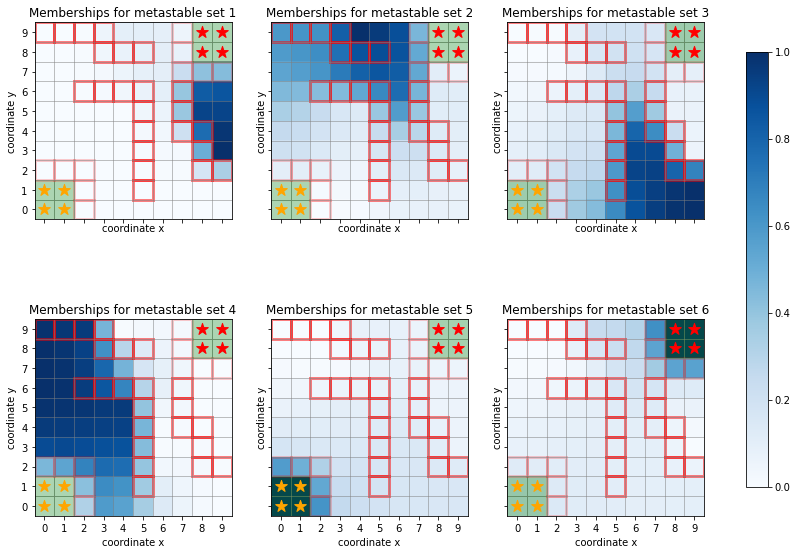

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    ax.set_title(f"Memberships for metastable set {i+1}")
    handles, labels = sim.plot_2d_map(ax, barrier_mode='hollow')

    Q = pcca.memberships[:, i].reshape(sim.grid_size)
    cb = ax.imshow(Q, interpolation='nearest', origin='lower', cmap=plt.cm.Blues);
norm = mpl.colors.Normalize(vmin=0, vmax=1)
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Blues), ax=axes, shrink=.8);

Also reactive fluxes can be coarse-grained by lumping together states - without systematic error as in the PCCA case. For simplicity, we coarse grain onto $A$, $B$, and the remainder subdivided into the upper half ($j\geq 5$) and the lower half.

In [15]:
remainder_upper = []
remainder_lower = []
for i in range(sim.grid_size[0]):
    for j in range(sim.grid_size[1]):
        state = sim.coordinate_to_state((i, j))
        if state not in sim.home_state + sim.bar_state:
            if j >= 5:
                remainder_upper.append(state)
            else:
                remainder_lower.append(state)

In [16]:
sets, tpt = flux.coarse_grain([sim.home_state, sim.bar_state, remainder_upper, remainder_lower])

As expected we obtain four sets which are exactly the home states, the bar states, and the subdivided remainder.

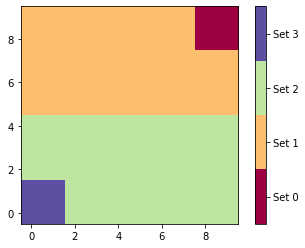

In [17]:
# enumerating assignments
assignments = np.zeros(sim.n_states)
for i, flux_set in enumerate(sets):
    assignments[np.array(list(flux_set))] = i
assignments = assignments.reshape(sim.grid_size)

# plot assignments
fig, ax = plt.subplots(1, 1)
cmap = plt.cm.get_cmap('Spectral', 4)
cb = ax.imshow(assignments, interpolation='nearest', origin='lower', 
               cmap=cmap, vmin=-.5, vmax=3.5)
cbar = fig.colorbar(cb, ticks=np.arange(4))
cbar.ax.set_yticklabels(['Set 0', 'Set 1', 'Set 2', 'Set 3']);

The return value also contains the fluxes plus derived quantities: The gross flux has a forward-backward cycle between upper and lower set, while the net flux lacks this cycle.

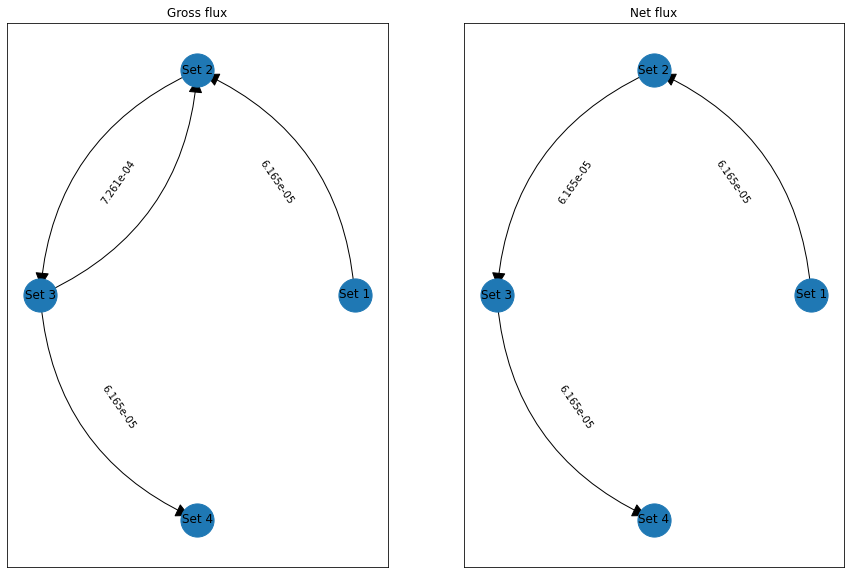

In [18]:
import networkx as nx

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
graphs = [nx.DiGraph() for _ in range(len(axes))]

for i in range(len(axes)):
    ax = axes[i]
    
    ax.set_title("Gross flux" if i == 0 else "Net flux")
    
    F = tpt.gross_flux if i == 0 else tpt.net_flux
    G = graphs[i]
    for i in range(len(sets)):
        G.add_node(i, title=f"Set {i+1}")
    for i in range(len(sets)):
        for j in range(len(sets)):
            if F[i, j] > 0:
                G.add_edge(i, j, title=f"{F[i, j]:.3e}")

    edge_labels = nx.get_edge_attributes(G, 'title')
    pos = nx.circular_layout(G)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=1100)
    nx.draw_networkx_labels(G, pos, ax=ax, labels=nx.get_node_attributes(G, 'title'));
    fragments = nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=edge_labels)
    nx.draw_networkx_edges(G, pos, ax=ax, arrowstyle='-|>', arrowsize=30,
                           connectionstyle='arc3, rad=0.3');

## Pathway decomposition

A pathway is a sequence of states $P=(s_1,s_2,\ldots,s_k)$ so that $s_1\in A$ and $s_k\in B$. One can associate a capacity (the minimal current) to a pathway via

$$
f(P) = \min\{ f_{s_i s_{i+1}}^{AB} : i=1,\ldots, k-1\}.
$$

A pathway decomposition is then the repeated choosing of a path and subsequent removal of its capacity along its edges until no flux remains.

The decomposition is not unique and depends on the order in which the paths are choosen. In deeptime, a pathway decomposition is implemented by iteratively removing the currently strongest pathway (i.e., with largest capacity).

A call to [pathways()](../api/generated/deeptime.markov.ReactiveFlux.rst#deeptime.markov.ReactiveFlux.pathways) performs said operation. One can optionally give a fraction (default 1.0) which stops the decomposition when the given fraction of the total flux is reached with the decomposition. The default tries to the flux into all dominant pathways which can be computationally intensive for large networks. Furthermore one can set a hard limit on the number of computed pathways via the `maxiter` argument.

In [19]:
paths, capacities = flux.pathways(fraction=.3, maxiter=1000)
print(len(paths))

4


In this example, we can represent $30\%$ of the total flux with four pathways.

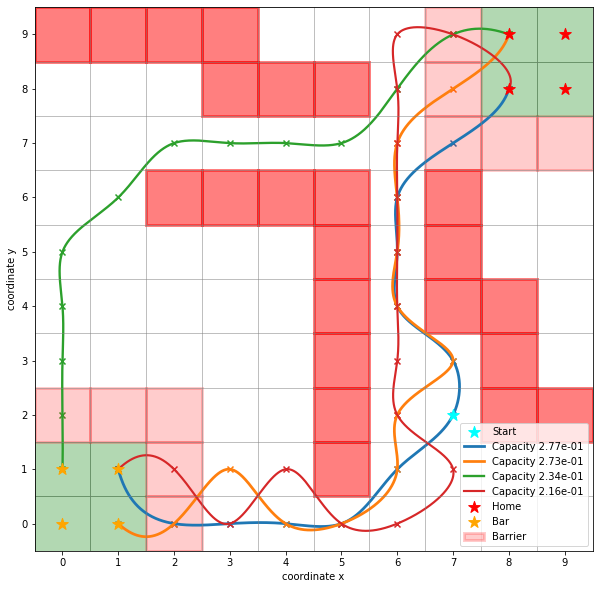

In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(*start, marker='*', label='Start', c='cyan', s=150, zorder=5)

for capacity, path in zip((capacities / np.array(capacities).sum())[:10], paths[:10]):
    path = np.array([sim.state_to_coordinate(state) for state in path])
    sim.plot_path(ax, path, lw=capacity*10, intermediates=False, 
                  color_lerp=False, label=f"Capacity {capacity:.2e}")
    ax.scatter(*path.T, marker='x')

handles, labels = sim.plot_2d_map(ax)
ax.legend(handles=handles, labels=labels);

## Example from trajectories

Using the same example we can generate timeseries which can be used to re-estimate a Markov state model and perform a TPT analysis. To this end, we simulate 1000 trajectories all starting from the same point and return the micro states directly rather than $(i, j)$ coordinates.

In [21]:
trajs = []
for _ in range(1000):
    trajs.append(sim.walk(start=start, n_steps=2000, return_states=True, stop=False))

From these trajectories we can count state transitions based on the prior knowledge that there are actually $100$ states and select the largest connected submodel - which due to the barriers does not contain all the states.

In [22]:
from deeptime.markov import TransitionCountEstimator

count_model = TransitionCountEstimator(1, 'sliding', n_states=sim.n_states) \
    .fit(trajs).fetch_model()
count_model = count_model.submodel_largest()

In [23]:
print(f"States not included in the count model: "
      f"{set(range(count_model.n_states_full)) - set(count_model.state_symbols)}")

States not included in the count model: {15, 25, 28, 29, 35, 38, 45, 47, 48, 55, 57, 62, 63, 64, 65, 67, 83, 84, 85, 90, 91, 92, 93}


Based on this we can estimate a Markov state model:

In [24]:
from deeptime.markov.msm import MaximumLikelihoodMSM

mlmsm = MaximumLikelihoodMSM().fit(count_model).fetch_model()

While we represent all counts in the markov state model, only a fraction of the states is represented - as expected:

In [25]:
print("Count fraction:", mlmsm.count_fraction)
print("State fraction:", mlmsm.state_fraction)

Count fraction: 1.0
State fraction: 0.77


On this we can compute the reactive flux:

In [26]:
flux = mlmsm.reactive_flux(
     mlmsm.count_model.symbols_to_states(sim.home_state), 
     mlmsm.count_model.symbols_to_states(sim.bar_state))

And perform the above described analyses, for example a pathway decomposition and the forward committor:

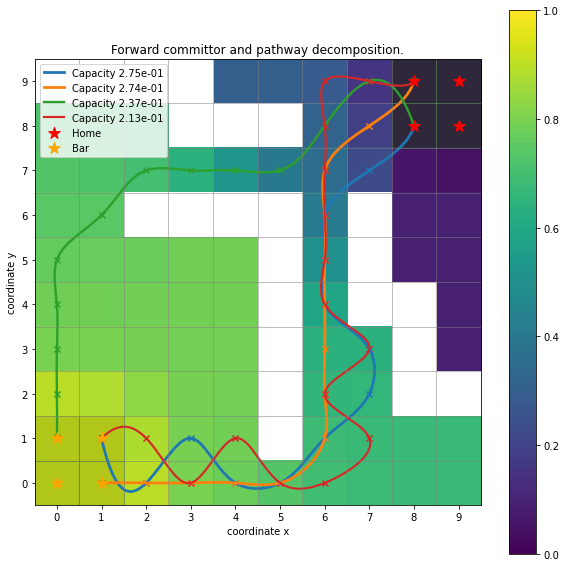

In [27]:
paths, capacities = flux.pathways(.3)

fig, ax = plt.subplots(figsize=(10, 10))

ax.set_title("Forward committor and pathway decomposition.")

for capacity, path in zip((capacities / np.array(capacities).sum())[:10], paths[:10]):
    path = mlmsm.count_model.states_to_symbols(path)
    path = np.array([sim.state_to_coordinate(state) for state in path])
    sim.plot_path(ax, path, lw=capacity*10, label=f"Capacity {capacity:.2e}",
                  intermediates=False, color_lerp=False)
    ax.scatter(*path.T, marker='x')

handles, labels = sim.plot_2d_map(ax, barriers=False)
    
Q = np.ones((sim.n_states))*np.nan
Q[mlmsm.state_symbols()] = flux.forward_committor
Q = Q.reshape(sim.grid_size)
    
cb = ax.imshow(Q, interpolation='nearest', origin='lower')
fig.colorbar(cb, ax=ax)

ax.legend(handles=handles, labels=labels);

Comparing this plot with the ones above one can notice that the hard barriers are 'missing', meaning that they were not sampled in the trajectories and now show up as white cubes due to the image being initialized as $10\times 10$ array filled with `np.nan`.